In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/Data 255 Spring 2024/Google Colab/Homework10'

/content/drive/My Drive/Data 255 Spring 2024/Google Colab/Homework9


In [ ]:
!pip install pytorch_pretrained_bert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 8.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manyl

In [ ]:
# private model that provides underlying implementations for linear algebra
import numpy.linalg._umath_linalg
print(numpy.linalg._umath_linalg.__file__)

/usr/local/lib/python3.10/dist-packages/numpy/linalg/_umath_linalg.cpython-310-x86_64-linux-gnu.so


In [ ]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import random
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regex as re
#from pymagnitude import Magnitude
from collections.abc import MutableMapping
from pytorch_pretrained_bert import BertTokenizer, BertForSequenceClassification, BertAdam
from sklearn.metrics import classification_report
from tqdm import tqdm, tqdm_notebook

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data.dataset import random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from IPython.core.display import display, HTML
from google_drive_downloader import GoogleDriveDownloader as gdd

tqdm.pandas()

# If the machine you run this on has a GPU available with CUDA installed,
# use it. Using a GPU for learning often leads to huge speedups in training.
# See https://developer.nvidia.com/cuda-downloads for installing CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
DATA_PATH = 'data/imdb_reviews.csv'
if not Path(DATA_PATH).is_file():
    gdd.download_file_from_google_drive(
        file_id='1zfM5E6HvKIe7f3rEt1V2gBpw5QOSSKQz',
        dest_path=DATA_PATH,
    )

In [ ]:
class ImdbSentimentDataset(Dataset):
    def __init__(self, data_path, max_len):
        # Read the dataset from the given CSV file path
        df = pd.read_csv(DATA_PATH)

        # Initialize BERT tokenizer from the 'bert-base-uncased' pretrained model
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        # Tokenize the reviews using the BERT tokenizer and limit the tokenized text to max_len - 2 tokens
        df['tokenized_text'] = df.review.progress_apply(self.tokenizer.tokenize)

        # Shorten to max length (Bert has a limit of 512); subtract two tokens for [CLS] and [SEP]
        df.loc[:, 'tokenized_text'] = df.tokenized_text.str[:max_len - 2]

        # Add Bert-specific beginning and end tokens
        df.loc[:, 'tokenized_text'] = df.tokenized_text.apply(
            lambda tokens: ['[CLS]'] + tokens + ['[SEP]'],
        )

        # Convert tokenized text into indexed tokens
        df['indexed_tokens'] = df.tokenized_text.progress_apply(
            self.tokenizer.convert_tokens_to_ids,
        )

        # Prepare sequences, attention masks, and segment IDs
        sequences = df.indexed_tokens.tolist()
        max_sequence_length = max(len(x) for x in sequences)

        self.inputs_lst, self.masks, self.segments = [], [], []
        for sequence in sequences:
            self.inputs_lst.append(sequence + (max_sequence_length - len(sequence)) * [0])
            self.masks.append(len(sequence) * [1] + (max_sequence_length - len(sequence)) * [0])
            self.segments.append(max_sequence_length * [0])

        # Store targets (labels) and texts (reviews)
        self.targets = df.label.tolist()
        self.texts = df.review.tolist()

    def __getitem__(self, i):
        # Return the indexed tokens, attention masks, and segment IDs
        return self.inputs_lst[i], self.masks[i], self.segments[i], self.targets[i], self.texts[i]

    def __len__(self):
        # Return the length of the dataset
        return len(self.inputs_lst)

In [ ]:
# How many tokens long each sequence will be cut to
# Shorter sequences will get the padding token <PAD>
max_len = 128  #@param {type:"slider", min:16, max:512, step:2}

dataset = ImdbSentimentDataset(DATA_PATH, max_len)

100%|██████████| 62155/62155 [00:01<00:00, 38988.06it/s]


In [ ]:
len(dataset)

62155

In [ ]:
#@title Splitting up the data

def split_train_valid_test(corpus, valid_ratio=0.1, test_ratio=0.1):
    """Split dataset into train, validation, and test."""
    test_length = int(len(corpus) * valid_ratio)
    valid_length = int(len(corpus) * test_ratio)
    train_length = len(corpus) - valid_length - test_length
    return random_split(
        corpus, lengths=[train_length, valid_length, test_length],
    )

valid_ratio = 0.01  #@param {type:"slider", min:0.01, max:0.3, step:0.01}
test_ratio = 0.01  #@param {type:"slider", min:0.01, max:0.3, step:0.01}

# Train on only a subset of the data to reduce training time
n_samples = 5000  #@param {type:"integer"}

train_dataset, valid_dataset, test_dataset = split_train_valid_test(
    dataset,
    valid_ratio,
    test_ratio,
)
train_dataset = Subset(train_dataset, torch.randperm(len(train_dataset))[:n_samples])
len(train_dataset), len(valid_dataset), len(test_dataset)

(5000, 621, 621)

In [ ]:
#@title How many examples to load on the GPU at once

def collate(batch):
    inputs = torch.LongTensor([item[0] for item in batch])
    mask = torch.LongTensor([item[1] for item in batch])
    segment = torch.LongTensor([item[2] for item in batch])
    target = torch.LongTensor([item[3] for item in batch])
    text = [item[4] for item in batch]

    inputs, mask, segment, target = map(
        lambda x: x.to(device),
        (inputs, mask, segment, target),
    )

    return inputs, mask, segment, target, text

batch_size = 32  #@param {type:"integer"}

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate)

In [ ]:
#@title How big of steps the model takes while learning

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = model.to(device)

learning_rate = 0.001  #@param {type:"number"}

param_optimizer = list(model.classifier.named_parameters())
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer]}]
optimizer = BertAdam(optimizer_grouped_parameters, lr=learning_rate)

100%|██████████| 407873900/407873900 [00:14<00:00, 27960496.13B/s]


In [ ]:
def train_epoch(model, optimizer, train_loader):
    model.train()
    train_loss = total = 0
    for inputs, mask, segment, target, text in tqdm_notebook(train_loader,
                                                             desc='Training',
                                                             leave=False):
        optimizer.zero_grad()

        loss = model(inputs, segment, mask, target)

        train_loss += loss.item()
        total += 1

        loss.backward()
        optimizer.step()

    return train_loss / total


def validate_epoch(model, valid_loader):
    model.eval()
    with torch.no_grad():
        valid_loss = total = 0
        for inputs, mask, segment, target, text in tqdm_notebook(valid_loader,
                                                                 desc='Validating',
                                                                 leave=False):
            loss = model(inputs, segment, mask, target)

            valid_loss += loss.item()
            total += 1

        return valid_loss / total

In [ ]:
#@title Limit the number of training epochs (training is slow)

max_epochs = 2  #@param {type:"slider", min:1, max:10}

n_epochs = 0
train_losses, valid_losses = [], []
while True:
    train_loss = train_epoch(model, optimizer, train_loader)
    valid_loss = validate_epoch(model, valid_loader)

    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.3f}\tvalid_loss: {valid_loss:.3f}\n',
    )

    # Early stopping if the current valid_loss is
    # greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss > loss for loss in valid_losses[-3:]):
        print('Stopping early')
        break

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    n_epochs += 1

    if n_epochs >= max_epochs:
        break

<ipython-input-14-6161870d6bb6>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, mask, segment, target, text in tqdm_notebook(train_loader,


Training:   0%|          | 0/157 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1630.)
  next_m.mul_(beta1).add_(1 - beta1, grad)
<ipython-input-14-6161870d6bb6>:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, mask, segment, target, text in tqdm_notebook(valid_loader,


Validating:   0%|          | 0/20 [00:00<?, ?it/s]

epoch #  1	train_loss: 0.691	valid_loss: 0.554



Training:   0%|          | 0/157 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

epoch #  2	train_loss: 0.589	valid_loss: 0.525



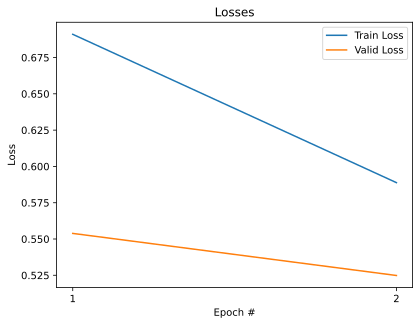

In [ ]:
epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

In [ ]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, mask, segment, target, text in test_loader:
        loss = model(inputs, segment, mask, target)
        logits = model(inputs, segment, mask)

        logits = logits.detach().cpu().numpy()
        predictions = np.argmax(logits, axis=1)
        target = target.cpu().numpy()

        y_true.extend(predictions)
        y_pred.extend(target)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.71      0.70       299
           1       0.73      0.71      0.72       322

    accuracy                           0.71       621
   macro avg       0.71      0.71      0.71       621
weighted avg       0.71      0.71      0.71       621



In [ ]:
flatten = lambda x: [sublst for lst in x for sublst in lst]
inputs_lst, mask_lst, segment_lst, target_lst, text_lst = zip(*test_loader)
inputs_lst, mask_lst, segment_lst, target_lst, text_lst = map(flatten, [inputs_lst, mask_lst, segment_lst, target_lst, text_lst])
test_examples = list(zip(inputs_lst, mask_lst, segment_lst, target_lst, text_lst))

def print_random_prediction(n=10):
    to_emoji = lambda x: '😄' if x else '😡'
    model.eval()
    rows = []
    for _ in range(n):
        with torch.no_grad():
            inputs, target, segment, target, text = random.choice(test_examples)

            logits = model(inputs.unsqueeze(0))
            logits = logits.detach().cpu().numpy()
            prediction = np.argmax(logits, axis=1)[0]

            predicted = to_emoji(prediction)
            actual = to_emoji(target)

            row = f"""
            <tr>
            <td>{text}&nbsp;</td>
            <td>{predicted}&nbsp;</td>
            <td>{actual}&nbsp;</td>
            </tr>
            """
            rows.append(row)

    rows_joined = '\n'.join(rows)
    table = f"""
<table>
<tbody>
<tr>
<td><b>Review</b>&nbsp;</td>
<td><b>Predicted</b>&nbsp;</td>
<td><b>Actual</b>&nbsp;</td>
</tr>
{rows_joined}
</tbody>
</table>
"""
    display(HTML(table))

In [ ]:
print_random_prediction(n=5)

Review,Predicted,Actual
"The films use of blue-black and vibrant skin tones to create a noir-ish feel to this movie unfortunately do not work. In fact its quite irritating as it obscures the demon characters and reduces them to one dimensional beings.At least the original had an hysterical energy and the gore set-pieces were quite stunning. Black gore is hardly frightening, nor is the main female demon at all frightening in her attempts to snarl and growl at the screen in her best camp Lugosi style.The narrative is grossly disjointed and if you could imagine 'Naked Lunch' directed by Russ Meyer you may appreciate the attempt to be William Burroughs-esque. Otherwise give this film a wide girth. Bava and Argento fans - once again - are bitterly disappointed.",😡,😡
"Seth McFarlane is a true genius. He has crafted a show that is witty, culturally sharp and just downright hilarious.For those that think its 'offensive' take on social or cultural topics makes no meaningful comment, just causes 'offence', can be pointed to this quote:Peter (coming out of the stem cell lab): How long was I in there? // Guard: Five minutes. // Peter: Why aren't we funding this?!?Why indeed.Thanks family guy, for being not only the funniest show on TV (with the possible exception of the much loved, much missed futurama), but for also being pretty clever to boot.",😡,😄
"It is important and only fair to remember that, at the time this short was produced, a state of war existed between the United States and the Empire of Japan. Add to that the enormous ill-will that the beginning of the war created, as well as the Bataan Death March and other incidents and the only thing surprising about this short and others is that there weren't more of them. One other thing: my only problem with this short is that it seems to try to be funny, but it isn't. I'm not sure that anyone connected with it really tried to make the jokes work, or even cared. It would have been far better if they had done what Disney did with Education For Death and been totally serious. But this short gets a bad rap and shouldn't be judged out of context. The times were different then and that is an important consideration. Anyone expending energy trying to save the world from a sixty-year old cartoon needs to take a step back. As do I, expending energy defending that same cartoon. This should be available to interested parties, even if not in wide circulation. Not a nice cartoon, but sometimes life isn't nice. Recommended",😄,😄
"I was bored, around 10pm, so I watched this movie. And I could not stop laughing. Everything was so ridiculous. The way the kids were acting like they were older than 11 just cracked me up. One of the kids had a ring, that supposedly killed people after 3 or so years. It gave me the impression that he wanted to be a gangster.It's pretty hard to take little kids seriously, especially when it has to do with eating worms. They act like everything is such a big deal, like if Billy (the main character) doesn't eat the worms then the world will end.This is a good movie for little kids (excluding the fact that a 5 year old says 'penis'), but not for teens or adults who don't want to waste their time.",😡,😡
"When this film gets it right it really gets it right. And when it goes wrong... I'd say that a full 3/4s of the film is great. I can even isolate the bad bit. It's everything that has to do with the romance. Everything that you need to know about it is said in the first five minutes but it drags on for about 30. I'd recommend skipping that section if you can. It does nothing except explain his exile. It should have been a minor plot point quickly thrust aside. Fortunately, the period from about 0-30 and 1:00-2:19 (The End) is excellent.There are a number of excellent performances in this film, and an equal number of terrible ones. Just like everything else in this movie the acting is either perfect or terrible. Peter Ustinov as the slimy one-eyed slave Kaptah is perfect. It is o